# 1. Import Libraries

In [22]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.10.1
Eager mode:  True
Hub version:  0.13.0
GPU is available


# 2. Load Dataset

In [2]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'train[20%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\indiz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteXQS95V\imdb_reviews-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\indiz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteXQS95V\imdb_reviews-test.…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\indiz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteXQS95V\imdb_reviews-unsup…

Dataset imdb_reviews downloaded and prepared to C:\Users\indiz\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


# 3. Initial Analysis

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot de

# 4. Model

In [7]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

In [19]:
# model = tf.keras.Sequential()
# model.add(hub_layer)
# model.add(tf.keras.layers.Dense(16, activation='relu'))
# model.add(tf.keras.layers.Dense(1))

def DNN_Model():
    model = Sequential()
    model.add(hub_layer)
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(1))
    
    return model

model = DNN_Model()
model.summary()

model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_22 (Dense)            (None, 1024)              21504     
                                                                 
 dense_23 (Dense)            (None, 256)               262400    
                                                                 
 dense_24 (Dense)            (None, 64)                16448     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 700,437
Trainable params: 700,437
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
40/40 [==============================] - 3s 52ms/step - loss: 0.7487 - accuracy: 0.8217 - val_loss: 0.4597 - val_accuracy: 0.9147
Epoch 2/20
40/40 [==============================] - 2s 51ms/step - loss: 0.2947 - accuracy: 0.9848 - val_loss: 0.3415 - val_accuracy: 0.9657
Epoch 3/20
40/40 [==============================] - 2s 49ms/step - loss: 0.2050 - accuracy: 0.9977 - val_loss: 0.3476 - val_accuracy: 0.9642
Epoch 4/20
40/40 [==============================] - 2s 54ms/step - loss: 0.1700 - accuracy: 0.9977 - val_loss: 0.3202 - val_accuracy: 0.9665
Epoch 5/20
40/40 [==============================] - 2s 49ms/step - loss: 0.1437 - accuracy: 0.9995 - val_loss: 0.3002 - val_accuracy: 0.9669
Epoch 6/20
40/40 [==============================] - 2s 53ms/step - loss: 0.1245 - accuracy: 0.9997 - val_loss: 0.2890 - val_accuracy: 0.9649
Epoch 7/20
40/40 [==============================] - 2s 49ms/step - loss: 0.1092 - accuracy: 0.9999 - val_loss: 0.2798 - val_accuracy: 0.9663
Epoch 8/20
40

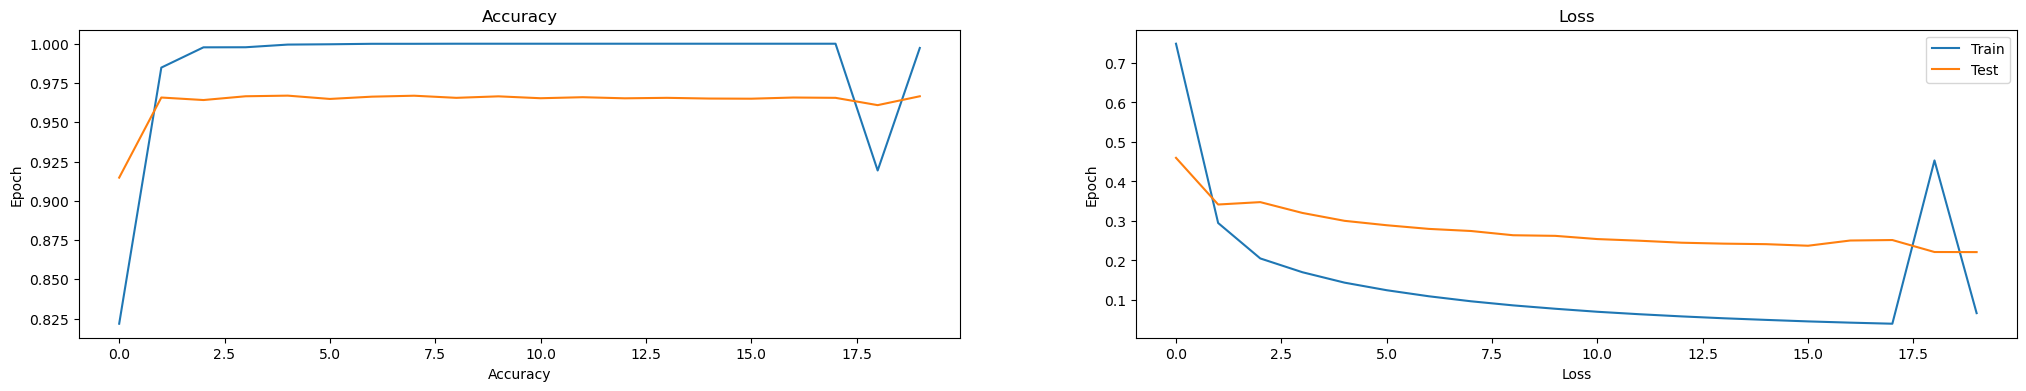

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

# 5. Evaluate Model

In [24]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

49/49 - 1s - loss: 0.8257 - accuracy: 0.8420 - 1s/epoch - 25ms/step
loss: 0.826
accuracy: 0.842
